# CS289A Project F: Random Forest

In [1]:
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd
import random
random.seed(246810)
np.random.seed(246810)
import warnings
warnings.filterwarnings('ignore')


In [2]:
eps = 1e-5  # a small number
# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000

h = np.vectorize(w)


## 1. Set up dataset

In [3]:
# some scripts to merge the SW time and HW time + features CSV files
# no need to run again !!

# path_chstone= '../data/baseline_chstone.csv'
# chstone = pd.read_csv(path_chstone, delimiter=',')

# path_random = '../data/baseline_random.csv'
# random = pd.read_csv(path_random, delimiter=',')
# random.sort_values(by = ['program'])

# random_sw=pd.read_csv('../data/sw_perf_random.csv', delimiter=',')
# chstone_sw=pd.read_csv('../data/sw_perf_chstone.csv', delimiter=',')

# merged_random = random.merge(random_sw, left_on='program', right_on='program')
# merged_chstone = chstone.merge(chstone_sw, left_on='program', right_on='program')

# merged_random.to_csv('../data/final_random.csv', index=False)
# merged_chstone.to_csv('../data/final_chstone.csv',index=False)


In [4]:
dataset = "csmith_random_programs"
data = pd.read_csv('../data/final_random.csv', delimiter=',')

### Part (a). Pre-process the data


In [5]:
# set out training set to be 70% of total; 30% 
# random_idx = random.randint(0, np.shape(data)[0]) #27
num_train = round(np.shape(data)[0]*0.7)
train_data = data.values[0:num_train,:]
test_data =  data.values[num_train:, :]
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(data))

train_speedup = (train_data[:, -1] / train_data[:, 2]) # 
test_speedup = (test_data[:, -1] / test_data[:, 2]) # -O3
print(train_speedup)
# log_train_speedup = np.log10(train_speedup.astype(float))
# log_test_speedup = np.log10(test_speedup.astype(float))


(9011, 116)
(3862, 116)
(12873, 116)
[2915.27039334195 3064.5126890095776 3127.9902745113 ...
 2596.5991783791956 2804.3891404735623 3077.551395099053]


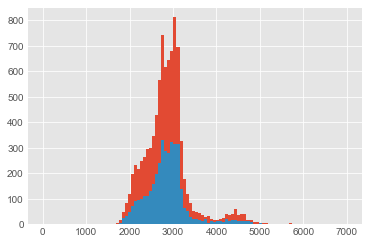

In [34]:
# EDA of speed up from training set
plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')
plt.hist(train_speedup, bins=100, range =(0, 7000))
plt.hist(test_speedup, bins=100, range = (0, 7000))

plt.show()


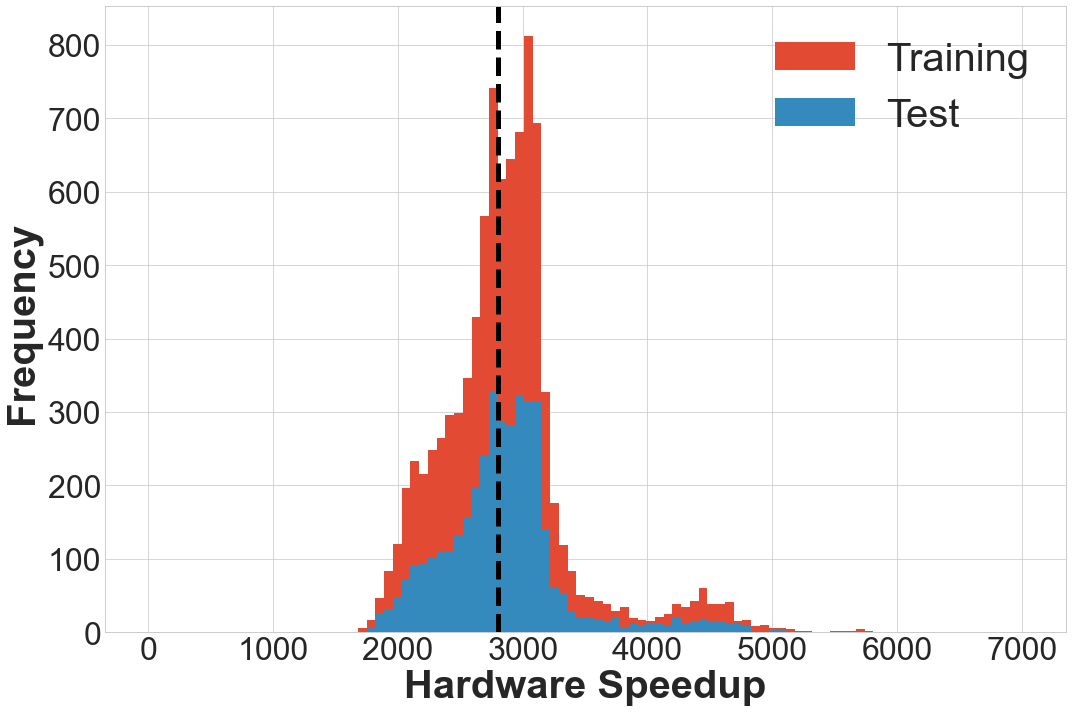

In [35]:
fontsize=40
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(15,10),nrows=1, ncols=1, constrained_layout=False)

ax.set_ylabel("Frequency ", fontsize=fontsize, weight='bold' )
ax.set_xlabel("Hardware Speedup", fontsize=fontsize,weight='bold' )
ax.tick_params(axis='x', labelsize=fontsize*0.8) # change the fontsize for xticks label (for all layers)
ax.tick_params(axis='y', labelsize=fontsize*0.8) # change the fontsize for xticks label (for all layers)


ax.yaxis.grid()
ax.xaxis.grid()


plt.hist(train_speedup, bins=100, range =(0, 7000))
plt.hist(test_speedup, bins=100, range =(0, 7000))
ax.legend(['Training', 'Test'], fontsize=fontsize, fancybox=True, framealpha=1.0)
plt.axvline(2800, lw=5, ls='--', color='black') 

ax.grid()
plt.tight_layout()
plt.savefig('random_speedup_dist.pdf')
plt.show()

In [38]:
# Get binary preduction output: is speedup (HW vs SW) > 2800 
y = (train_speedup > 2800).astype(int)
X = train_data[:,-57:-1]
y_test = (test_speedup > 2800).astype(int)
X_test = test_data[:,-57:-1]
print(np.count_nonzero(y) / len(y))
print(np.count_nonzero(y_test) / len(y_test))
assert(len(y) == np.shape(train_data)[0])
assert(len(y_test) == np.shape(test_data)[0] )

features = data.columns.values[-57:-1]
assert len(features) == 56
class_names = ["On-Chip", "Not On-Chip"]

0.5433359227610698
0.5468669083376488


In [39]:
def evaluate(clf, print_splits=True):
    print("Cross validation", cross_val_score(clf, X, y, cv=3))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        if print_splits == True:
            print("First splits", first_splits)

In [7]:

# # 
# # Basic decision tree
# print('==============================================')
# print("sklearn's decision tree")
# params = {
#     "max_depth": 5,
#     "min_samples_leaf": 20,
# }
# clf = DecisionTreeClassifier(random_state=0, **params)
# clf.fit(X, y)
# evaluate(clf, print_splits=True)

sklearn's decision tree
Cross validation [0.76464714 0.76198402 0.78354978]


In [144]:
from pydot import graph_from_dot_data
import io
out = io.StringIO()
export_graphviz(clf, out_file=out, feature_names=features, class_names=class_names)
# For OSX, may need the following for dot: brew install gprof2dot
graph = graph_from_dot_data(out.getvalue())
graph_from_dot_data(out.getvalue())[0].write_pdf("{}-tree-depth{}.pdf".format(dataset, max_depth))

In [145]:
class BaggedTrees(BaseEstimator, ClassifierMixin):

    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTreeClassifier(random_state=i, **self.params) for i in range(self.n)
        ]

    def fit(self, X, y):
        for i in range(self.n):
            idx = np.random.randint(0, X.shape[0], X.shape[0])
            newX, newy = X[idx, :], y[idx]
            self.decision_trees[i].fit(newX, newy)
        return self

    def predict(self, X):
        yhat = [self.decision_trees[i].predict(X) for i in range(self.n)]
        # TODO: compute yhat_avg for BaggedTrees
        ### start code ###
        yhat_avg = np.round(np.mean(yhat, axis=0), decimals=0)
        ### end code ###
        return yhat_avg
# Bagged trees
# print(" bagged trees")
# bt = BaggedTrees(params, n=N)
# bt.fit(X, y)
# evaluate(bt)

In [148]:
# class RandomForest(BaggedTrees):

#     def __init__(self, params=None, n=200, m=1):
#         if params is None:
#             params = {}
#         params['max_features'] = m
#         super().__init__(params=params, n=n)
        
# class BoostedRandomForest(RandomForest):

#     def fit(self, X, y):
#         self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
#         self.a = np.zeros(self.n)  # Weights on decision trees
#         i = 0
#         while i < self.n:
#             idx = np.random.choice(X.shape[0], size=X.shape[0], p=self.w)
#             newX, newy = X[idx, :], y[idx]
#             self.decision_trees[i].fit(newX, newy)
#             wrong = np.abs((y - self.decision_trees[i].predict(X)))
#             error = wrong.dot(self.w) / np.sum(self.w)
#             self.a[i] = 0.5 * np.log((1 - error) / error)
#             # Update w
#             wrong_idx = np.where(wrong > 0.5)[0]
#             right_idx = np.where(wrong <= 0.5)[0]
#             # TODO: fill in the code for updating 'self.w'
            
#             ### start code ###
#             self.w[wrong_idx] = self.w[wrong_idx]*np.exp(self.a[i])
#             self.w[right_idx] = self.w[right_idx]*np.exp(-self.a[i])
#             self.w = self.w / sum(self.w)
#             #print(self.w)
#             i += 1
#         ### end code ###
#         return self
    
#     def predict(self, X):
#         yhat = [self.a[i]*self.decision_trees[i].predict(X) for i in range(self.n)]
#         yhat_BoostedRandomForest = np.round(np.sum(yhat, axis=0) / np.sum(self.a))
#         return yhat_BoostedRandomForest

In [40]:
params_rf = {
    "max_depth": 5,
    "min_samples_leaf": 30,
    "n_estimators": 500,
    "min_samples_split":2
}
max_depth = 5
rf = RandomForestClassifier(**params_rf, max_features=np.int(np.sqrt(X.shape[1])))
rf.fit(X, y)
print(cross_val_score(rf, X, y, scoring='accuracy', cv=3))
print('random forest test accuracy: ', accuracy_score(rf.predict(X_test), y_test))
print(len(rf.estimators_))


KeyboardInterrupt: 

In [41]:
scores=np.zeros((40,10))
for n in range (20, 30):
    for m in range(1, 10) :
        rf = RandomForestClassifier(n_estimators=n*20, min_samples_leaf=m*4,max_features=np.int(np.sqrt(X.shape[1])))
        rf.fit(X, y)
        scores[n,m] =  accuracy_score(rf.predict(X_test), y_test)
print(scores)
print(np.max(scores))
print(np.unravel_index(np.argmax(scores), (40,10)))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.

In [88]:
# grad_scores=np.zeros((40,10,5))
# for n in range (1, 40):
#     for m in range(1, 10) :
#         for l in range(1,5):
#             grad = GradientBoostingClassifier(n_estimators=n*20, min_samples_leaf=m*4, learning_rate=0.1*l,max_features=np.int(np.sqrt(X.shape[1])))
#             grad.fit(X, y)
#             grad_scores[n,m,l] =  accuracy_score(grad.predict(X_test), y_test)
print(np.max(grad_scores))
print(np.unravel_index(np.argmax(grad_scores), (40,10,5)))

0.771620921802175
(3, 4, 1)


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

logreg = LogisticRegression(random_state=1)
gnb = GaussianNB()

params_rf = {
    "max_depth": 5,
    "min_samples_leaf": 10,
    "n_estimators": 200,
    "random_state":0,
    "min_samples_split":2
}

params_ada = {
    #"max_depth": 5,
    #"min_samples_leaf": 10,
    "n_estimators": 200,
    "random_state":0,
    #"min_samples_split":2
}

params_grad = {
    #"max_depth": 5,
    #"min_samples_leaf": 10,
    "n_estimators": 200,
    "random_state":0,
    #"min_samples_split":2
}

rf = RandomForestClassifier(**params_rf, max_features=np.int(np.sqrt(X.shape[1])))
ext = ExtraTreesClassifier(**params_rf, max_features=np.int(np.sqrt(X.shape[1])))
ada = AdaBoostClassifier(**params_ada)
grad = GradientBoostingClassifier(**params_grad, max_features=np.int(np.sqrt(X.shape[1])))
eclf = VotingClassifier(estimators=[('lr', logreg), ('gnb', gnb), ('rf', rf), ('ext', ext),('ada', ada), ('grad', grad)], voting='hard')

for clf, label in zip([logreg, gnb, rf, ext,ada,grad,eclf], [
    'Logistic Regression', 'naive Bayes',
    'Random Forest', 'Extra Trees', "AdaBoost", "Gradient Boosting",'Voting Classfier']):
    clf.fit(X,y)
    cross_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
    test_scores = accuracy_score(clf.predict(X_test), y_test)
    print("Cross validation: %0.4f (+/- %0.2f) [%s]" % (cross_scores.mean(), cross_scores.std(), label))
    print("Test accuracy: %0.4f (+/- %0.2f) [%s]" % (test_scores.mean(), test_scores.std(), label))

Cross validation: 0.7645 (+/- 0.01) [Logistic Regression]
Test accuracy: 0.7589 (+/- 0.00) [Logistic Regression]
Cross validation: 0.7614 (+/- 0.01) [naive Bayes]
Test accuracy: 0.7576 (+/- 0.00) [naive Bayes]
Cross validation: 0.7716 (+/- 0.01) [Random Forest]
Test accuracy: 0.7698 (+/- 0.00) [Random Forest]
Cross validation: 0.7646 (+/- 0.01) [Extra Trees]
Test accuracy: 0.7582 (+/- 0.00) [Extra Trees]
Cross validation: 0.7691 (+/- 0.01) [AdaBoost]
Test accuracy: 0.7628 (+/- 0.00) [AdaBoost]
Cross validation: 0.7692 (+/- 0.01) [Gradient Boosting]
Test accuracy: 0.7644 (+/- 0.00) [Gradient Boosting]
Cross validation: 0.7677 (+/- 0.01) [Voting Classfier]
Test accuracy: 0.7701 (+/- 0.00) [Voting Classfier]


In [ ]:
params = {
    #"max_depth": 5,
    #"min_samples_leaf": 10,
    "random_state":0,
    "min_samples_split":2
}

# Constant classifier
print('==============================================')
print("Constant classifier")
print('constant classifier test accuracy: ', accuracy_score(np.zeros_like(y_test), y_test))


# Basic decision tree
print('==============================================')
print("Decsion Tree classifier")
clf = DecisionTreeClassifier(**params)
clf.fit(X, y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('sklearn decision tree test accuracy: ', accuracy_score(clf.predict(X_test), y_test))


params = {
    "max_depth": 5,
    "min_samples_leaf": 10,
    "n_estimators": 300,
    "random_state":0,
    "min_samples_split":2
}

# Random forest
print('==============================================')
print("Random Forest classifier")
rf = RandomForestClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
rf.fit(X, y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('random forest test accuracy: ', accuracy_score(rf.predict(X_test), y_test))

from sklearn.ensemble import ExtraTreesClassifier
print('==============================================')
print("Extremely Randomized Forest classifier")
ext = ExtraTreesClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
ext.fit(X,y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('Extreme random forest test accuracy: ', accuracy_score(ext.predict(X_test), y_test))   
                           
# Gradient boosted random forest
print('==============================================')
print("Gradient Boosting classifier")
boosted = GradientBoostingClassifier(**params, max_features=np.int(np.sqrt(X.shape[1])))
boosted.fit(X, y)
print("cross validation {}".format(cross_val_score(rf, X, y, cv=5)))
print('boosted random forest test accuracy: ', accuracy_score(boosted.predict(X_test), y_test))
# np.savetxt('{}.out'.format(dataset), boosted.predict(X_test))